# Perceptron training

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We consider the binary classification of labels $\mathcal{Y}=\{-1,1\}$. A perceptron is a model based on a linear decision boundary given by $f_{w,b}(x)\triangleq w^Tx+b$ and corresponding classifier $\hat y_{w,b}(x)=\text{sign}(f_{w,b}(x))$, which attempts to minimize the Bayes risk, defined for $f:\mathbb{R}^d\to \{-1,1\}$ by:

$$\mathcal{R}(f)\triangleq \mathbb{P}(f(X)\neq Y)$$

In the following we consider data sampled from a distribution $(X,Y)\in \mathbb{R}^d\times\{-1,1\}$ and our goal is to solve:
$$\inf_{(w,b)\in \mathbb{R}^{d+1}}\mathcal{R}(\hat y_{w,b})\quad (1).$$

We propose to minimize the empirical risk obtained from $n$ iid samples:

$$\mathcal{R}_n(\hat y_{w,b})\triangleq \frac 1n\sum_{i=1}^n1_{\hat y_{w,b}(X_i)\neq Y_i}$$

which leads to the minimization:

$$\inf_{(w,b)\in \mathbb{R}^{d+1}}\mathcal{R}_n(\hat y_{w,b})\quad (2)$$.

__Q1 (Minimization of the empirical risk):__ Compute $\mathbb{E}[\mathcal{R}_n(\hat y_{w,b})]$.

__Q2 (Dataset generation):__ (a) Propose two functions to generate some data obtained from the following densities (verify they are densities!): 

$p_1(x,y)=\frac 121_{y=-1}\frac{1}{(2\pi)^{d/2}4\sigma^d}e^{-\frac{\Vert x\Vert ^2}{32\sigma^2}}+\frac 121_{y=1}\frac{1}{\sigma^d(2\pi)^{d/2}}e^{-\frac{\Vert x\Vert ^2}{2\sigma^2}}$ and $p_2(x,y)=\frac 121_{y=-1}\frac{1}{(2\pi)^{d/2}\sigma^d}e^{-\frac{\Vert x\Vert^2}{2\sigma^2}}+\frac 121_{y=1}(\frac 12\frac{1}{(2\pi)^{d/2}\sigma^d}e^{-\frac{\Vert x-e_1\Vert^2}{2\sigma^2}}+\frac 12\frac{1}{(2\pi)^{d/2}\sigma^d}e^{-\frac{\Vert x-10e_{1}\Vert^2}{2\sigma^2}})$. Here, $e_1$ is the first vector of the canonical basis.

(b) Plot 100 points samples from $p_1,p_2$ respectively.

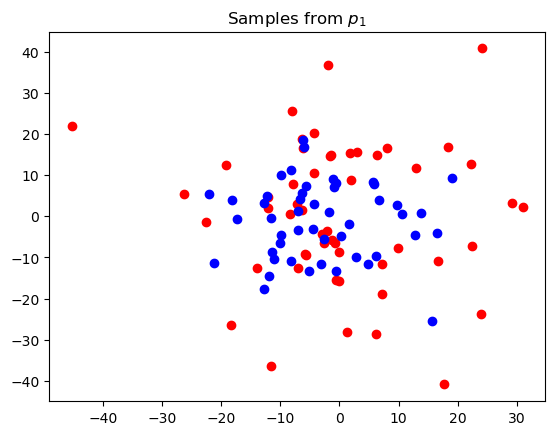

In [2]:
def sample_from_distribution_1(d=2,N=1,sigma=1):
    """
    Return the N samples following distribution p_1
    
    Parameters:
        - d (int): ambient dimension.
        - N (int): number of samples.
        - sigma (float): variance of the distribution.
    Returns:
        - X (np.array): samples of shape (N,d).
        - Y (np.array): labels with values in {-1,1} of shape (d).
    """

    mean = np.zeros(d)
    X=np.zeros([N,d])
    cov = sigma**2*np.eye(d)

    gauss = np.zeros([2,N,d])
    gauss[0,:,:] = np.random.multivariate_normal(mean, cov, size=N)
    gauss[1,:,:] = np.random.multivariate_normal(mean, 4*cov, size=N)
    Y = np.random.randint(0,2,size=N)
    for i in range(N):
        X[i,:]=gauss[Y[i],i,:]
    Y=2*Y-1
    return X, Y

X1,Y1=sample_from_distribution_1(N=100,sigma=10)


plt.scatter(X1[Y1==1,0],X1[Y1==1,1],label='Data',c='r')
plt.scatter(X1[Y1==-1,0],X1[Y1==-1,1],label='Data',c='b')
plt.title('Samples from $p_1$')
plt.show()

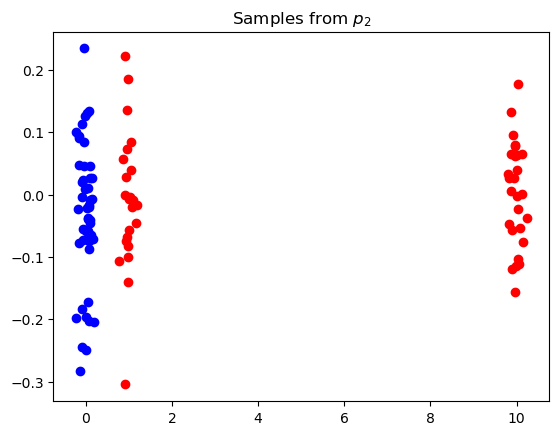

In [3]:
def sample_from_distribution_2(d=2,N=1,sigma=1):
    """
    Return the N samples following distribution p_2
    
    Parameters:
        - d (int): ambien dimension.
        - N (int): number of samples.
        - sigma (float): variance of the distribution.
    Returns:
        - X (np.array): samples of shape (N,d).
        - Y (np.array): labels with values in {-1,1} of shape (d).
    """

    mean1 = np.zeros(d)
    mean2 =np.zeros(d)
    mean3 =np.zeros(d)
    mean2[0]=1
    mean3[0]=10
    X=np.zeros([N,d])
    cov = sigma**2*np.eye(d)

    gauss = np.zeros([3,N,d])
    gauss[0,:,:] = np.random.multivariate_normal(mean1, cov, size=N)
    gauss[1,:,:] = np.random.multivariate_normal(mean2, cov, size=N)
    gauss[2,:,:] = np.random.multivariate_normal(mean3, cov, size=N)
    Y = np.random.binomial(1,0.5,size=N)
    z = np.random.binomial(1,0.5,size=N)
    for i in range(N):
        if Y[i]==0:
            X[i,:]=gauss[0,i,:]
        else:
            if z[i]==0:
                X[i,:]=gauss[1,i,:]
            else:
                X[i,:]=gauss[2,i,:]
    Y=2*Y-1
    return X, Y

X2,Y2=sample_from_distribution_2(N=100,sigma=0.1)


plt.scatter(X2[Y2==1,0],X2[Y2==1,1],label='Data',c='r')
plt.scatter(X2[Y2==-1,0],X2[Y2==-1,1],label='Data',c='b')
plt.title('Samples from $p_2$')
plt.show()

__Q3 (Classic perceptron (Rosenblatt, 1957)):__ The classical algorithm to minimize (1) is given by:
        
````
for t=1..T
   sample i in {1,...,n}
   if Y_i(w^T.X_i+b)<0 then
      w <- w + Y_i X_i
      b <- b + Y_i b
````

Implement this strategy with a tracker of the training error accross iterations.

In [4]:
def train_classic_perceptron(X,Y,T):
    """
    Train a perceptron using the Rosenblatt's algorithm.
    
    Parameters:
        - X (np.array): input samples.
        - Y (np.array): labels
        - T (int): number of iterations
    Returns:
        - w (np.array): vector of size (d).
        - b (np.array): bias of size (1).
        - error (list): list of intermediate errors
    """
    error=[]
    w=np.zeros([X.shape[1]])
    b=np.zeros([1])
    for t in range(T):
        i = np.random.randint(0,X.shape[0])
        if Y[i]*(w@X[i,:].T+b)<=0:
            r=Y[i]-(w@X[i,:].T+b)
            w=w+r*X[i,:]
            b=b+r
            error.append(r)
    return w, b, error


__Q4 (Minimization via the quadratic loss):__ While the 0-1 loss is not differentiable, a classical strategy is to use a differentiable loss to approximate it. Here, we introduce the quadratic loss:
$$\ell(\hat y,y)\triangleq \frac 12\Vert y-\hat y\Vert^2\,.$$

For training, we will use the Stochastic Gradient Descent (SGD), in order to minimize the corresponding empirical risk given by:

$$\tilde{\mathcal{R}}_n( f_{w,b})\triangleq \frac 1n \sum_{i=1}^n \ell(\hat f_{w,b}(X_i),Y_i)\,.$$

An estimate of the gradient is defined as:
$$g(w,b)\triangleq \nabla_{(w,b)}\ell(\hat y_{w,b}(X_\mathbf{i}),Y_\mathbf{i})$$ where $\mathbf{i}$ is random variable, which corresponds to a uniform sampling over $\{1,...,n\}$.

Then, once an initial point 
$(w_0,b_0)\in \mathbb{R}^{d+1}$ is picked, the following iterative descent procedure is followed, for some $\eta>0$:

$$(w_{n+1},b_{n+1})=(w_{n},b_{n})-\eta g(w_{n},b_{n})\quad(3)$$

(a) Compute $g(w,b)$ and $\mathbb{E}[g(w,b)]$ and propose a classifier.

(b) Implement the descent of *(3)*, with a tracker of the training loss accross iterations.

In [5]:
def train_SGD_perceptron(X,Y,T,eta=0.1):
    """
    Train a perceptron using SGD.
    
    Parameters:
        - X (np.array): input samples.
        - Y (np.array): labels
        - T (int): number of iterations
        - eta (float): step size (also known as learning rate)
    Returns:
        - w (np.array): vector of size (d).
        - b (np.array): bias of size (1).
        - error (list): list of intermediate errors
    """
    error=[]
    w=np.zeros([X.shape[1]])
    b=np.zeros([1])
    for t in range(T):
        i = np.random.randint(0,X.shape[0])
        r=(w@X[i,:].T+b)-Y[i]
        w = w - eta * r * X[i,:]
        b = b - eta * r
        error.append(r)
    return w, b, error

__Q5:__ Test your model on both datasets for $d=2$. Plot the hyper-plane separator and the evolution of the training loss. Comment.

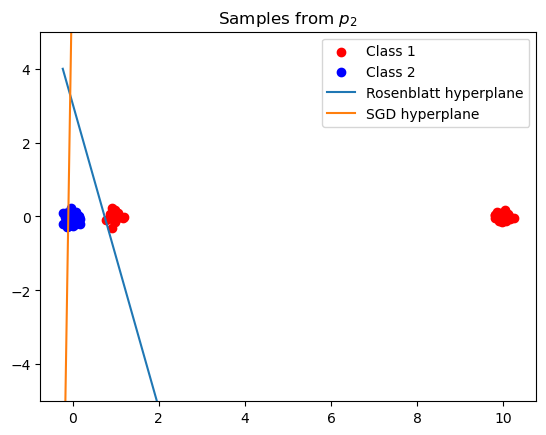

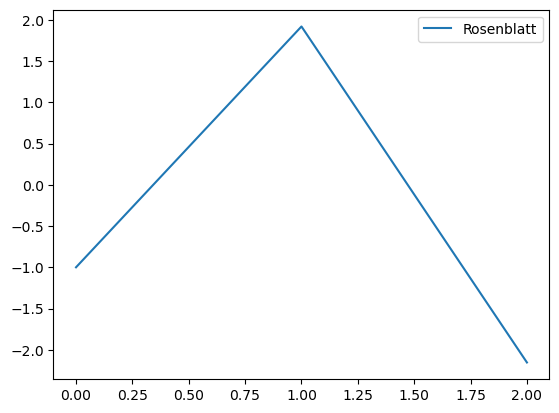

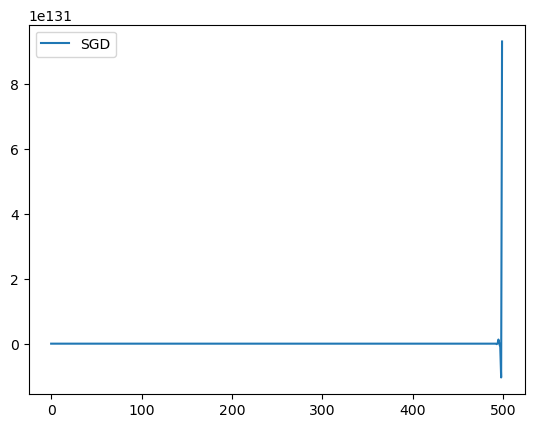

In [6]:
X=X2
Y=Y2
w_c,b_c,error_c=train_classic_perceptron(X,Y,500)
w_s,b_s,error_s=train_SGD_perceptron(X,Y,500)
plt.scatter(X[Y==1,0],X[Y==1,1],label='Class 1',c='r')
plt.scatter(X[Y==-1,0],X[Y==-1,1],label='Class 2',c='b')
x=np.linspace(min(X[:,0]),max(X[:,0]))
y_c=-w_c[0]/w_c[1]*x-b_c/w_c[1]
y_s=-w_s[0]/w_s[1]*x-b_s/w_s[1]
plt.ylim([-5, 5])
plt.plot(x,y_c, label='Rosenblatt hyperplane')
plt.plot(x,y_s, label='SGD hyperplane')
plt.title('Samples from $p_2$')
plt.legend()
plt.show()



plt.plot(error_c, label='Rosenblatt')

plt.legend()
plt.show()
plt.plot(error_s,label='SGD')
plt.legend()
plt.show()

/var/folders/g4/tj0645wn5gn1_0fzbhn38w500000gn/T/ipykernel_94477/3913658927.py:19: RuntimeWarning: overflow encountered in matmul
  if Y[i]*(w@X[i,:].T+b)<=0:
/var/folders/g4/tj0645wn5gn1_0fzbhn38w500000gn/T/ipykernel_94477/3913658927.py:19: RuntimeWarning: invalid value encountered in matmul
  if Y[i]*(w@X[i,:].T+b)<=0:
/var/folders/g4/tj0645wn5gn1_0fzbhn38w500000gn/T/ipykernel_94477/3913658927.py:20: RuntimeWarning: overflow encountered in matmul
  r=Y[i]-(w@X[i,:].T+b)
/var/folders/g4/tj0645wn5gn1_0fzbhn38w500000gn/T/ipykernel_94477/3913658927.py:19: RuntimeWarning: invalid value encountered in add
  if Y[i]*(w@X[i,:].T+b)<=0:
/var/folders/g4/tj0645wn5gn1_0fzbhn38w500000gn/T/ipykernel_94477/3913658927.py:21: RuntimeWarning: invalid value encountered in add
  w=w+r*X[i,:]
/var/folders/g4/tj0645wn5gn1_0fzbhn38w500000gn/T/ipykernel_94477/3913658927.py:22: RuntimeWarning: invalid value encountered in add
  b=b+r


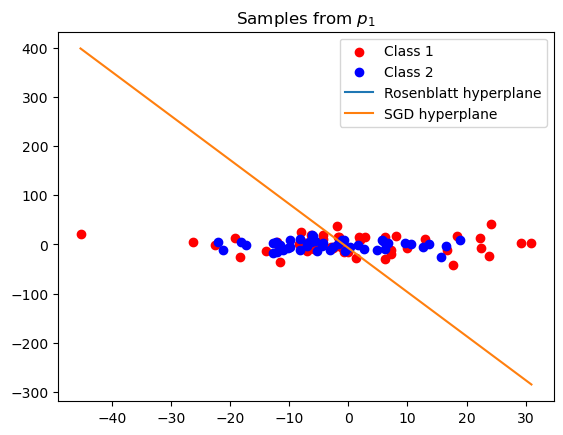

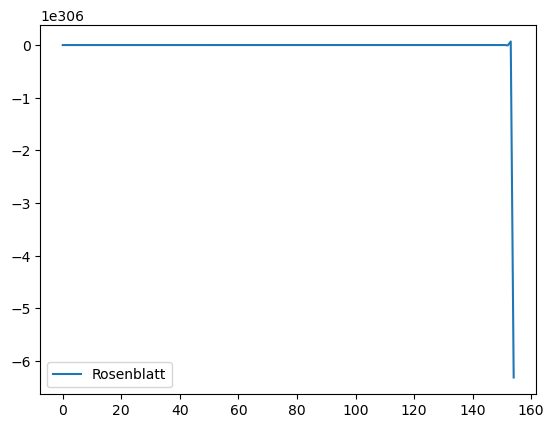

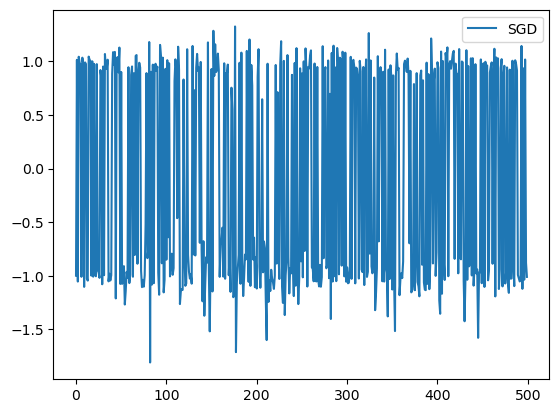

In [7]:
X=X1
Y=Y1
w_c,b_c,error_c=train_classic_perceptron(X,Y,500)
w_s,b_s,error_s=train_SGD_perceptron(X,Y,500,eta=0.0001)
plt.scatter(X[Y==1,0],X[Y==1,1],label='Class 1',c='r')
plt.scatter(X[Y==-1,0],X[Y==-1,1],label='Class 2',c='b')
x=np.linspace(min(X[:,0]),max(X[:,0]))
y_c=-w_c[0]/w_c[1]*x-b_c/w_c[1]
y_s=-w_s[0]/w_s[1]*x-b_s/w_s[1]
plt.plot(x,y_c, label='Rosenblatt hyperplane')
plt.plot(x,y_s, label='SGD hyperplane')
plt.title('Samples from $p_1$')
plt.legend()
plt.show()



plt.plot(error_c, label='Rosenblatt')

plt.legend()
plt.show()
plt.plot(error_s,label='SGD')
plt.legend()
plt.show()

__Q6:__ Would you classify tanks on satellite images with a Perceptron? (source: https://www.jefftk.com/p/detecting-tanks )